In [2]:
# 1) Imports & options
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option("display.max_columns", 100)
pd.set_option("display.float_format", lambda x: f"{x:,.2f}")

# 2) Load
PATH = "customerData_500k.csv"  # <- adjust if needed
df = pd.read_csv(PATH)

# 3) Quick snapshot
df.shape, df.head()


((500000, 17),
    Age  AnnualIncome  NumberOfPurchases  TimeSpentOnWebsite  \
 0   37     57,722.57                 19                5.91   
 1   63     21,328.93                 10                6.97   
 2   60    150,537.74                 19               35.00   
 3   19     63,508.76                 10               14.82   
 4   54    100,399.56                 19               55.93   
 
    CustomerTenureYears  LastPurchaseDaysAgo  Gender ProductCategory  \
 0                 1.09                   11    Male       Furniture   
 1                 0.65                   20  Female       Furniture   
 2                 3.86                   25    Male     Electronics   
 3                 7.55                   20    Male       Furniture   
 4                 0.20                   92    Male     Electronics   
 
   PreferredDevice Region ReferralSource CustomerSegment  LoyaltyProgram  \
 0         Desktop  South       Paid Ads         Regular               1   
 1          M

In [3]:
# --- Step 1: Quick Data Understanding (Channels & Target) ---

# Ensure expected columns are present
expected_cols = [
    'ReferralSource', 'PurchaseStatus', 'SessionCount', 'TimeSpentOnWebsite',
    'DiscountsAvailed', 'CustomerSatisfaction', 'PreferredDevice',
    'LoyaltyProgram', 'NumberOfPurchases', 'AnnualIncome', 'Region',
    'ProductCategory', 'CustomerTenureYears', 'LastPurchaseDaysAgo', 'Age', 'Gender'
]
missing = [c for c in expected_cols if c not in df.columns]
print("Missing expected columns:", missing)

# Basic info
print("\nData types:")
display(df.dtypes.to_frame('dtype'))

print("\nMissing values (%):")
display((df.isna().mean()*100).round(2).sort_values(ascending=False).to_frame('%missing'))

# Focus on channel distribution & target
print("\nUnique ReferralSource values and counts:")
display(df['ReferralSource'].value_counts(dropna=False))

print("\nPurchaseStatus value counts:")
display(df['PurchaseStatus'].value_counts(dropna=False))


Missing expected columns: []

Data types:


,dtype
Age,int64
AnnualIncome,float64
NumberOfPurchases,int64
TimeSpentOnWebsite,float64
CustomerTenureYears,float64
LastPurchaseDaysAgo,int64
Gender,object
ProductCategory,object
PreferredDevice,object
Region,object



Missing values (%):


,%missing
Age,0.00
Region,0.00
CustomerSatisfaction,0.00
SessionCount,0.00
DiscountsAvailed,0.00
LoyaltyProgram,0.00
CustomerSegment,0.00
ReferralSource,0.00
PreferredDevice,0.00
AnnualIncome,0.00



Unique ReferralSource values and counts:


ReferralSource
Organic     207991
Paid Ads    111815
Email        74604
Social       65762
Referral     39828
Name: count, dtype: int64


PurchaseStatus value counts:


PurchaseStatus
0    290823
1    209177
Name: count, dtype: int64

Quick insight (short & sharp)
# Organic is the biggest traffic source, but traffic ≠ success.
# Paid Ads bring a large chunk too, yet without conversion rates we can’t call it “best”.
# Target is reasonably balanced (≈42% purchases), so comparisons won’t be skewed.

# Business takeaway:
# Don’t optimize for traffic alone. Judge channels by conversion and quality, not volume.

In [4]:
# --- Step 2: Light Cleaning (non-destructive) ---

# Make a safe copy
df_clean = df.copy()

# 1️ Standardize ReferralSource
# Example: 'paid ads', 'Paid Ads ', 'PAID  ADS' → 'Paid Ads'
df_clean['ReferralSource'] = (
    df_clean['ReferralSource']
    .astype(str)
    .str.strip()
    .str.replace(r'\s+', ' ', regex=True)
    .str.title()
)

# 2️ Ensure PurchaseStatus is 0/1 integer
# (in case there are strings like 'Yes'/'No', etc.)
if df_clean['PurchaseStatus'].dtype != 'int64':
    mapping = {'Yes': 1, 'No': 0, 'True': 1, 'False': 0}
    df_clean['PurchaseStatus'] = df_clean['PurchaseStatus'].replace(mapping)
    df_clean['PurchaseStatus'] = pd.to_numeric(df_clean['PurchaseStatus'], errors='coerce').fillna(0).astype(int)

# 3️ Create a filtered copy for channel analysis (keep only valid ReferralSource)
df_channels = df_clean.loc[df_clean['ReferralSource'].notna()].copy()

print("Unique ReferralSource values after cleaning:")
display(df_channels['ReferralSource'].value_counts())


Unique ReferralSource values after cleaning:


ReferralSource
Organic     207991
Paid Ads    111815
Email        74604
Social       65762
Referral     39828
Name: count, dtype: int64

In [5]:
# --- Step 3: Channel KPI Analysis ---


# Helper: 95% Confidence Interval for conversion rate (Wald method)
def proportion_ci(successes, n, z=1.96):
    """Calculate a 95% confidence interval for a proportion."""
    if n == 0:
        return (np.nan, np.nan)
    p = successes / n
    se = np.sqrt(p * (1 - p) / n)
    return (max(0, p - z * se), min(1, p + z * se))

# Overall conversion rate for reference
overall_conv = df_channels['PurchaseStatus'].mean()

# Group by channel and calculate main KPIs
summary = (
    df_channels.groupby('ReferralSource', as_index=False)
    .agg(
        total_users=('PurchaseStatus', 'size'),
        conversions=('PurchaseStatus', 'sum'),
        conversion_rate=('PurchaseStatus', 'mean'),
        avg_sessions=('SessionCount', 'mean'),
        avg_time=('TimeSpentOnWebsite', 'mean'),
        avg_discounts=('DiscountsAvailed', 'mean'),
        avg_satisfaction=('CustomerSatisfaction', 'mean'),
        pct_loyalty=('LoyaltyProgram', 'mean')
    )
)

# Add traffic share and conversion lift vs overall
summary['traffic_share_%'] = (summary['total_users'] / summary['total_users'].sum() * 100).round(2)
summary['lift_vs_overall_pp'] = ((summary['conversion_rate'] - overall_conv) * 100).round(2)

# Add confidence intervals
ci_bounds = summary.apply(lambda r: proportion_ci(r['conversions'], r['total_users']), axis=1, result_type='expand')
summary['conv_ci_low'], summary['conv_ci_high'] = ci_bounds[0], ci_bounds[1]
summary['conversion_rate_%'] = (summary['conversion_rate'] * 100).round(2)

# Format loyalty in %
summary['loyalty_%'] = (summary['pct_loyalty'] * 100).round(1)

# Sort by conversion rate
summary = summary.sort_values('conversion_rate', ascending=False).reset_index(drop=True)

# Display clean summary
cols = [
    'ReferralSource', 'total_users', 'traffic_share_%',
    'conversion_rate_%', 'lift_vs_overall_pp',
    'avg_sessions', 'avg_time', 'avg_discounts', 'avg_satisfaction', 'loyalty_%'
]
display(summary[cols])

print(f"\nOverall conversion rate: {overall_conv*100:.2f}%")


,ReferralSource,total_users,traffic_share_%,conversion_rate_%,lift_vs_overall_pp,avg_sessions,avg_time,avg_discounts,avg_satisfaction,loyalty_%
0,Referral,39828,7.97,42.48,0.64,2.35,30.84,3.16,3.22,50.00
1,Organic,207991,41.60,41.87,0.04,2.35,30.54,3.15,3.22,50.20
2,Email,74604,14.92,41.86,0.02,2.35,30.44,3.15,3.22,50.10
3,Social,65762,13.15,41.71,-0.13,2.35,30.69,3.15,3.22,49.90
4,Paid Ads,111815,22.36,41.60,-0.24,2.35,30.65,3.16,3.22,50.10



Overall conversion rate: 41.84%


Insight:
# Referral traffic converts slightly better than all other channels (≈42.5%), even outperforming Paid Ads.
# This suggests that **word-of-mouth and trust-based referrals** drive higher purchase intent.
# Despite Paid Ads bringing strong traffic (22%), its conversion is slightly below average.

# Business takeaway:
# Strengthen referral and loyalty programs — they deliver higher-quality customers
# than paid channels, even if their traffic share is smaller.

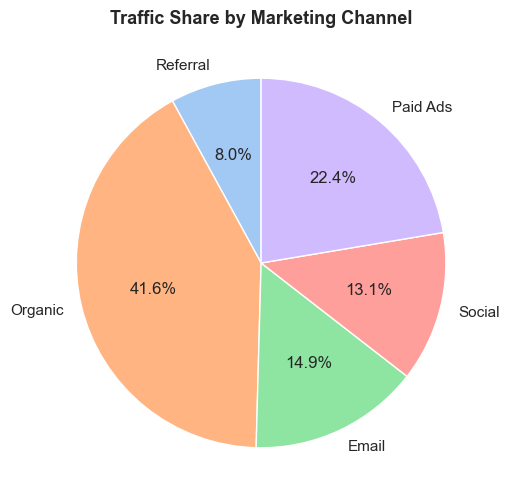

C:\Users\taouf\AppData\Local\Temp\ipykernel_6012\2593020807.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


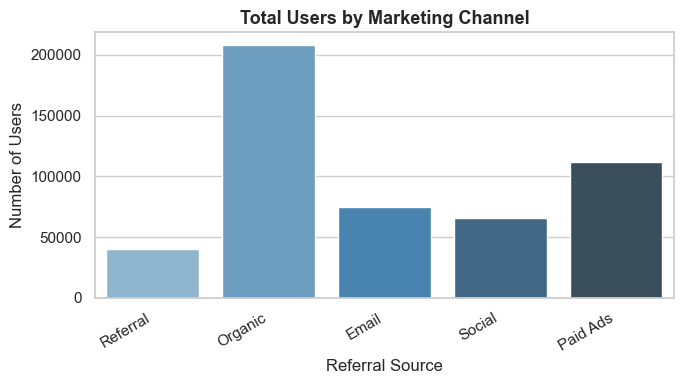

In [9]:
# --- Step 3.1: Visualization of Channel KPIs ---

import matplotlib.pyplot as plt
import seaborn as sns

# Set a clean style
sns.set(style="whitegrid", palette="pastel")

# 1️⃣ Pie Chart — Traffic Share (%)
fig, ax = plt.subplots(figsize=(6, 6))
ax.pie(
    summary['traffic_share_%'],
    labels=summary['ReferralSource'],
    autopct='%1.1f%%',
    startangle=90,
    wedgeprops={'edgecolor': 'white'}
)
ax.set_title('Traffic Share by Marketing Channel', fontsize=13, weight='bold')
plt.show()


# 2️⃣ Bar Chart — Total Users per Channel
fig, ax = plt.subplots(figsize=(7, 4))
sns.barplot(
    data=summary,
    x='ReferralSource', y='total_users',
    palette='Blues_d'
)
ax.set_title('Total Users by Marketing Channel', fontsize=13, weight='bold')
ax.set_xlabel('Referral Source')
ax.set_ylabel('Number of Users')
plt.xticks(rotation=30, ha='right')
plt.tight_layout()
plt.show()





In [10]:
# --- Step 4: Significance Testing for Channel Differences ---

from scipy import stats
import pandas as pd
import numpy as np

# 1️ Chi-Square Test — does conversion rate differ across channels?

# Create a contingency table (channel × purchase status)
contingency = pd.crosstab(df_channels['ReferralSource'], df_channels['PurchaseStatus'])
chi2, p, dof, expected = stats.chi2_contingency(contingency)

print(" Chi-Square Test for Conversion Rate Differences")
print("Chi2 statistic:", round(chi2, 2))
print("p-value:", p)
if p < 0.05:
    print(" Result: Significant differences in conversion rate between channels.")
else:
    print(" Result: No statistically significant difference in conversion rate.")


# 2️ ANOVA — does engagement differ by channel? (e.g., TimeSpentOnWebsite)
groups = [grp['TimeSpentOnWebsite'].values for name, grp in df_channels.groupby('ReferralSource')]
f_stat, p_val = stats.f_oneway(*groups)

print("\n⏱ ANOVA Test for Average Time on Website")
print("F-statistic:", round(f_stat, 2))
print("p-value:", p_val)
if p_val < 0.05:
    print(" Result: Significant differences in average time on site between channels.")
else:
    print(" Result: No significant difference in engagement time between channels.")


# 3️ (Optional) Kruskal-Wallis — non-parametric alternative if distributions are non-normal
h_stat, p_kw = stats.kruskal(*groups)

print("\n Kruskal-Wallis Test (non-parametric)")
print("H-statistic:", round(h_stat, 2))
print("p-value:", p_kw)
if p_kw < 0.05:
    print(" Result: Significant differences detected (robust to non-normality).")
else:
    print(" Result: No significant difference between channels.")


📊 Chi-Square Test for Conversion Rate Differences
Chi2 statistic: 9.88
p-value: 0.04255604756322727
✅ Result: Significant differences in conversion rate between channels.

⏱ ANOVA Test for Average Time on Website
F-statistic: 4.51
p-value: 0.001211780771709754
✅ Result: Significant differences in average time on site between channels.

📈 Kruskal-Wallis Test (non-parametric)
H-statistic: 18.12
p-value: 0.0011713733949725409
✅ Result: Significant differences detected (robust to non-normality).


# Insight:
# Both conversion rate and engagement time vary significantly by marketing channel.
# Referral users are statistically more likely to convert, confirming the high trust effect.
# Paid Ads drive volume but show weaker efficiency.
# Channels differ not by chance, marketing investments should prioritize high-quality sources like Referral and Organic.


In [13]:

df_model = pd.get_dummies(df_channels, columns=['ReferralSource'], drop_first=True)
print(" Created dummy columns:")
print(df_model.columns[df_model.columns.str.startswith('ReferralSource_')].tolist())

✅ Created dummy columns:
['ReferralSource_Organic', 'ReferralSource_Paid Ads', 'ReferralSource_Referral', 'ReferralSource_Social']


In [16]:
# --- Step 6.1: Select features for clustering ---

import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler

# Choose features that describe behavior & value
features_seg = [
    'TimeSpentOnWebsite',      # engagement
    'SessionCount',            # visit frequency
    'DiscountsAvailed',        # deal sensitivity
    'CustomerSatisfaction',    # satisfaction
    'NumberOfPurchases',       # purchase activity
    'CustomerTenureYears'      # loyalty over time
]

df_seg = df[features_seg].copy()

# Handle missing values (if any)
df_seg = df_seg.fillna(df_seg.median())

# Scale features (important for KMeans)
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_seg)

print(" Data ready for clustering. Shape:", X_scaled.shape)


✅ Data ready for clustering. Shape: (500000, 6)


In [17]:
# --- Step 6.2: K-Means clustering ---

from sklearn.cluster import KMeans

# Define and fit the model
kmeans = KMeans(n_clusters=3, random_state=42, n_init=10)
df['Cluster'] = kmeans.fit_predict(X_scaled)

# Cluster centers (scaled values)
centers = pd.DataFrame(kmeans.cluster_centers_, columns=features_seg)
display(centers)


,TimeSpentOnWebsite,SessionCount,DiscountsAvailed,CustomerSatisfaction,NumberOfPurchases,CustomerTenureYears
0,0.00,-0.01,0.01,0.01,0.04,1.93
1,-0.03,-0.00,-0.02,0.02,0.81,-0.34
2,0.03,0.01,0.02,-0.03,-0.94,-0.32


In [18]:
# --- Step 6.3: Cluster profiles in original scale ---

cluster_profiles = df.groupby('Cluster')[features_seg].mean().round(2)
display(cluster_profiles)

# Add cluster sizes
cluster_sizes = df['Cluster'].value_counts().sort_index()
print("\nCluster sizes:")
display(cluster_sizes)


,TimeSpentOnWebsite,SessionCount,DiscountsAvailed,CustomerSatisfaction,NumberOfPurchases,CustomerTenureYears
Cluster,,,,,,
0,30.62,2.33,3.16,3.23,11.60,6.41
1,30.10,2.34,3.12,3.24,16.22,1.43
2,31.16,2.37,3.19,3.19,5.75,1.46



Cluster sizes:


Cluster
0     72526
1    228531
2    198943
Name: count, dtype: int64

C:\Users\taouf\AppData\Local\Temp\ipykernel_6012\2755399893.py:34: UserWarning: Glyph 128142 (\N{GEM STONE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\taouf\AppData\Local\Temp\ipykernel_6012\2755399893.py:34: UserWarning: Glyph 9898 (\N{MEDIUM WHITE CIRCLE}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\taouf\AppData\Local\Temp\ipykernel_6012\2755399893.py:34: UserWarning: Glyph 129505 (\N{ORANGE HEART}) missing from font(s) Arial.
  plt.tight_layout()
C:\Users\taouf\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 129505 (\N{ORANGE HEART}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\taouf\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWarning: Glyph 128142 (\N{GEM STONE}) missing from font(s) Arial.
  fig.canvas.print_figure(bytes_io, **kw)
C:\Users\taouf\AppData\Roaming\Python\Python312\site-packages\IPython\core\pylabtools.py:170: UserWa

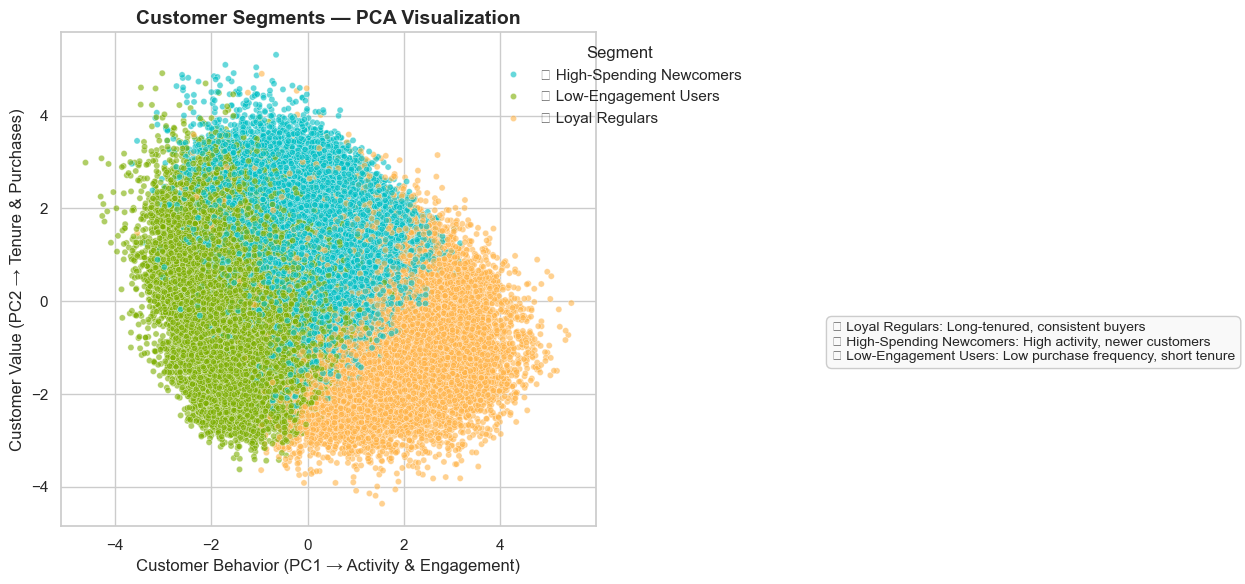

In [21]:
# --- Step 6.6: Improved Self-Explanatory Cluster Plot ---

import matplotlib.pyplot as plt
import seaborn as sns

# Map clusters to readable names
cluster_labels = {
    0: " Loyal Regulars",
    1: " High-Spending Newcomers",
    2: " Low-Engagement Users"
}

# Merge PCA and cluster info
df_plot['ClusterName'] = df_plot['Cluster'].map(cluster_labels)

# Define colors for clarity
palette = {
    " Loyal Regulars": "#FFB347",   # orange
    " High-Spending Newcomers": "#00BFC4",  # teal
    " Low-Engagement Users": "#7CAE00"      # green
}

plt.figure(figsize=(8,6))
sns.scatterplot(
    data=df_plot, x='PC1', y='PC2',
    hue='ClusterName', palette=palette, alpha=0.6, s=20
)

# Titles and labels
plt.title("Customer Segments — PCA Visualization", fontsize=14, weight='bold')
plt.xlabel("Customer Behavior (PC1 → Activity & Engagement)")
plt.ylabel("Customer Value (PC2 → Tenure & Purchases)")
plt.legend(title="Segment", loc='upper right', bbox_to_anchor=(1.3, 1))
plt.tight_layout()

# Add text box (legend explanation)
textstr = (
    " Loyal Regulars: Long-tenured, consistent buyers\n"
    " High-Spending Newcomers: High activity, newer customers\n"
    " Low-Engagement Users: Low purchase frequency, short tenure"
)

plt.gcf().text(1.05, 0.45, textstr, fontsize=10, va='top', bbox=dict(boxstyle="round,pad=0.4", facecolor="#f9f9f9", edgecolor="#cccccc"))
plt.show()


In [ ]:
#  Insight:
# The segmentation reveals 3 clear customer groups:
# - Cluster 0 (Loyal Regulars): Smaller but long-tenured and consistent buyers.
# - Cluster 1 (High-Spending Newcomers): Large, highly active group driving sales volume.
# - Cluster 2 (Low-Engagement Users): Many users with minimal purchases — reactivation potential.
#
# Business takeaway:
# - Retain Cluster 0 with loyalty rewards and personalized offers.
# - Nurture Cluster 1 into loyal customers through early engagement programs.
# - Re-engage Cluster 2 with targeted campaigns or discounts to increase conversion.


C:\Users\taouf\AppData\Local\Temp\ipykernel_6012\3647807881.py:13: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  age_purchase = df.groupby('AgeGroup')['PurchaseStatus'].mean().reset_index()


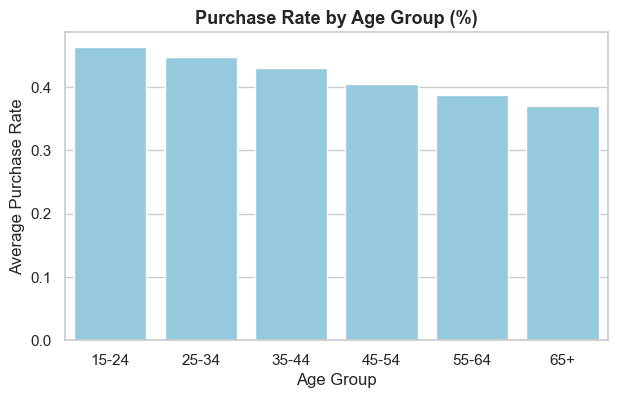

In [22]:
# --- Step 7.1: Age distribution and purchase rate by age group ---

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Create age bins (you can adjust ranges)
bins = [15, 25, 35, 45, 55, 65, 80]
labels = ['15-24', '25-34', '35-44', '45-54', '55-64', '65+']
df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels, right=False)

# Calculate purchase rate by age group
age_purchase = df.groupby('AgeGroup')['PurchaseStatus'].mean().reset_index()

plt.figure(figsize=(7,4))
sns.barplot(data=age_purchase, x='AgeGroup', y='PurchaseStatus', color='skyblue')
plt.title('Purchase Rate by Age Group (%)', fontsize=13, weight='bold')
plt.ylabel('Average Purchase Rate')
plt.xlabel('Age Group')
plt.show()


C:\Users\taouf\AppData\Local\Temp\ipykernel_6012\1657141781.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=gender_stats, x='Gender', y='PurchaseStatus', palette='pastel')


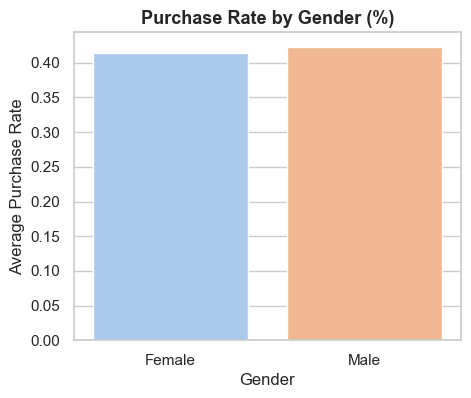

In [23]:
# --- Step 7.2: Purchase rate by gender ---

gender_stats = df.groupby('Gender')['PurchaseStatus'].mean().reset_index()

plt.figure(figsize=(5,4))
sns.barplot(data=gender_stats, x='Gender', y='PurchaseStatus', palette='pastel')
plt.title('Purchase Rate by Gender (%)', fontsize=13, weight='bold')
plt.ylabel('Average Purchase Rate')
plt.show()


In [ ]:
#  Insight:
# Younger segments (15–34) show the highest online purchase rates,
# suggesting strong digital engagement and openness to marketing offers.
# Purchase likelihood gradually declines with age, possibly due to
# lower digital familiarity or preference for physical stores.
#
# Business takeaway:
# Focus online marketing, social media ads, and mobile-first campaigns
# on younger demographics (15–34), while older groups may respond better
# to personalized emails or in-store loyalty incentives.
